In [8]:
#import necessary libraries
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import scipy.ndimage as nd
from tensorflow import keras
%matplotlib inline
import pylab as pl
from IPython import display


import sys
sys.path.append("..") # Adds higher directory to python modules path.

import branchingdnn as branching
from branchingdnn import core
from branchingdnn.utils import * 
from branchingdnn.profiler import model_profiler as profiler
from branchingdnn.dataset import prepare
from branchingdnn.branches import branch

# from tensorflow.examples.tutorials.mnist import input_data

In [9]:
# Download MNIST dataset
# mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
# print(y_train)
K= 10 # number of classes

In [10]:
train_images = train_images.reshape(60000, 784).astype("float32") / 255
test_images = test_images.reshape(10000, 784).astype("float32") / 255


train_labels = tf.keras.utils.to_categorical(train_labels,10)
test_labels = tf.keras.utils.to_categorical(test_labels,10)

print(len(train_labels))
print(len(test_labels))
print(train_labels[0])
print((test_labels[0]))
# plt.imshow(train_images[1].reshape(228,228)) 
# plt.show()

60000
10000
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


In [11]:
validation_size = 12000
shuffle_size = 20000
batch_size=128
validation_images, validation_labels = train_images[:validation_size], train_labels[:validation_size] #get the first 5k training samples as validation set
train_images, train_labels = train_images[validation_size:], train_labels[validation_size:] # now remove the validation set from the training set.
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
validation_ds = tf.data.Dataset.from_tensor_slices((validation_images, validation_labels))


def augment_images(image, label):
    # Normalize images to have a mean of 0 and standard deviation of 1
    # image = tf.image.per_image_standardization(image)
    # Resize images from 32x32 to 277x277
    # image = tf.image.resize(image, (28,28))
    return image, label
train_ds_size = len(list(train_ds))
test_ds_size = len(list(test_ds))
validation_ds_size = len(list(validation_ds))
train_ds = (train_ds.map(augment_images))
validation_ds = (validation_ds.map(augment_images))
test_ds = (test_ds.map(augment_images))

target = tf.data.Dataset.from_tensor_slices((train_labels))
train_ds = tf.data.Dataset.zip((train_ds,target))

v_target = tf.data.Dataset.from_tensor_slices((validation_labels))
validation_ds = tf.data.Dataset.zip((validation_ds,v_target))

t_target = tf.data.Dataset.from_tensor_slices((test_labels))
test_ds = tf.data.Dataset.zip((test_ds,t_target))


print("trainSize {}".format(train_ds_size))
print("testSize {}".format(test_ds_size))
train_ds = (train_ds
                
                .shuffle(buffer_size=tf.cast(shuffle_size,'int64'))
                .batch(batch_size=batch_size, drop_remainder=True))

test_ds = (test_ds
               
                #   .shuffle(buffer_size=train_ds_size)
                .batch(batch_size=1, drop_remainder=True))

validation_ds = (validation_ds
               
                #   .shuffle(buffer_size=validation_ds_size)
                .batch(batch_size=batch_size, drop_remainder=True))



trainSize 48000
testSize 10000


In [68]:
# This function to generate evidence is used for the first example
def relu_evidence(logits):
    return tf.nn.relu(logits)

# This one usually works better and used for the second and third examples
# For general settings and different datasets, you may try this one first
def exp_evidence(logits): 
    return tf.exp(tf.clip_by_value(logits,-10,10))

# This one is another alternative and 
# usually behaves better than the relu_evidence 
def softplus_evidence(logits):
    return tf.nn.softplus(logits)
    
def KL(alpha):
    # print("K:",K)
    beta=tf.constant(np.ones((1,K)),dtype=tf.float32)
    S_alpha = tf.reduce_sum(alpha,axis=1,keepdims=True)
    S_beta = tf.reduce_sum(beta,axis=1,keepdims=True)
    lnB = tf.compat.v1.lgamma(S_alpha) - tf.reduce_sum(tf.compat.v1.lgamma(alpha),axis=1,keepdims=True)
    lnB_uni = tf.reduce_sum(tf.compat.v1.lgamma(beta),axis=1,keepdims=True) - tf.compat.v1.lgamma(S_beta)
    
    dg0 = tf.compat.v1.digamma(S_alpha)
    dg1 = tf.compat.v1.digamma(alpha)
    
    kl = tf.reduce_sum((alpha - beta)*(dg1-dg0),axis=1,keepdims=True) + lnB + lnB_uni
    # print("kl", kl)
    return kl
def mse_loss(labels, alpha): 
        S = tf.reduce_sum(alpha, axis=1, keepdims=True) 
        E = alpha - 1
        m = alpha / S

        A = tf.reduce_sum((labels-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 

#         annealing_coef = tf.minimum(1.0,tf.cast(global_step/annealing_step,tf.float32))
        annealing_coef = 1
        alp = E*(1-labels) + 1 
        # print("alp", alp)
#         C =  annealing_coef * KL(alp)
#         print(alpha)
        C = keras_kl(labels, alpha)
        return (A + B) + C
    
    
def loss_function(annealing_rate=1, momentum=1, decay=1):
    #create a wrapper function that returns a function
    temperature = 1
    Classes = 10
    keras_kl = tf.keras.losses.KLDivergence()
    
    annealing_rate = annealing_rate
    momentum_rate = momentum
    decay_rate = decay
    
    
    def mse_loss(labels, alpha): 
        S = tf.reduce_sum(alpha, axis=1, keepdims=True) 
        E = alpha - 1
        m = alpha / S

        A = tf.reduce_sum((labels-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 

#         annealing_coef = tf.minimum(1.0,tf.cast(global_step/annealing_step,tf.float32))
        annealing_coef = 1
        alp = E*(1-labels) + 1 
        # print("alp", alp)
#         C =  annealing_coef * KL(alp)
#         print(alpha)
        C = keras_kl(labels, alpha)
        return (A + B) + C
    
    def mse_loss_global(labels, outputs): 
        evidence = softplus_evidence(outputs)
        alpha = evidence + 1
        S = tf.reduce_sum(alpha, axis=1, keepdims=True) 
        E = alpha - 1
        m = alpha / S

        A = tf.reduce_sum((labels-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 

        annealing_coef = tf.minimum(1.0,tf.cast(annealing_rate,tf.float32))
#         annealing_coef = 1
        alp = E*(1-labels) + 1 
        # print("alp", alp)
        C =  annealing_coef * KL(alp)
#         print(alpha)
#         C = keras_kl(labels, alpha)
        return (A + B) + C
    return  mse_loss_global





In [102]:
class EvidenceEndpoint(keras.layers.Layer):
        def __init__(self, num_outputs, name=None, **kwargs):
            super(EvidenceEndpoint, self).__init__(name=name)
            self.num_outputs = num_outputs
#             self.kl = tf.keras.losses.KLDivergence()
            self.loss_fn = loss_function()
#             self.loss_fn = tf.keras.losses.categorical_crossentropy
            self.evidence = relu_evidence
#             self.evidence = tf.compat.v1.distributions.Dirichlet
            self.temperature = 10
            self.lmb = 0.005
        def build(self, input_shape):
            self.kernel = self.add_weight("kernel", shape=[int(input_shape[-1]), self.num_outputs])
        
        def get_config(self):
            config = super().get_config().copy()
            config.update({
                'num_outputs': self.num_outputs,
                'name': self.name
            })
            return config

        def call(self, inputs, labels,learning_rate=1):
            outputs = tf.matmul(inputs,self.kernel)
#             print(outputs)
            softmax = tf.nn.softmax(outputs)
#             print(softmax)
#             print(labels)
            evidence = softplus_evidence(outputs)
            alpha = evidence + 1

#             loss = tf.reduce_mean(self.loss_fn(labels, outputs))
            u = self.num_outputs / tf.reduce_sum(alpha, axis=1, keepdims=True) #uncertainty
            prob = alpha/tf.reduce_sum(alpha, 1, keepdims=True) 
            l2_loss = tf.nn.l2_loss(self.weights) * self.lmb
#             total_loss = loss + l2_loss
            self.add_loss(l2_loss)
            pred = tf.argmax(outputs,1)
# #             print("pred", pred)
#             results = tf.one_hot(pred,self.num_outputs)
            truth = tf.argmax(labels,1)
# #             print("truth", truth)
            match = tf.reshape(tf.cast(tf.equal(pred, truth), tf.float32),(-1,1))
# #             print("match", match)
            total_evidence = tf.reduce_sum(evidence,1, keepdims=True)
            mean_avg = tf.reduce_mean(total_evidence)
            mean_succ = tf.reduce_sum(tf.reduce_sum(evidence,1, keepdims=True)*match) / tf.reduce_sum(match+1e-20)
            mean_fail = tf.reduce_sum(tf.reduce_sum(tf.reduce_sum(evidence,1, keepdims=True)*(1-match)) / (tf.reduce_sum(tf.abs(1-match))+1e-20) )




            self.add_metric(evidence, name=self.name+"_evidence")
            self.add_metric(mean_avg, name=self.name+"_mean_ev_avg")
            self.add_metric(mean_succ, name=self.name+"_mean_ev_succ")
            self.add_metric(mean_fail, name=self.name+"_mean_ev_fail")
            
            
#             total_loss =tf.reduce_mean(normal_loss) + l2_loss
            # print(total_loss)
#             total_evidence = tf.reduce_sum(evidence,1, keepdims=True) 
            # print(total_evidence)
#             pred = tf.argmax(outputs, 1)
#             truth = tf.argmax(labels, 1)
#             match = tf.reshape(tf.cast(tf.equal(pred, truth), tf.float32),(-1,1))
#             # print("match",match)
#             
#             # print("mean_Avg")


            # print('metrics')
#             self.add_loss(total_loss)
            # print("pred",inputs)
            # print("loss")
     
            
            return softmax
    

In [110]:
outputs =[]
inputs = keras.Input(shape=(784,))
targets = keras.Input(shape=(10,),name='targets')
x = layers.Flatten(input_shape=(28,28))(inputs)
x = layers.Dense(512, activation="relu")(x)
x= layers.Dropout(0.2)(x)
#exit 2
x = layers.Dense(512, activation="relu")(x)
x= layers.Dropout(0.2)(x)
#exit 3
x = layers.Dense(512, activation="relu")(x)
x= layers.Dropout(0.2)(x)
#exit 4
x = layers.Dense(512, activation="relu")(x)
x= layers.Dropout(0.2)(x)
#exit 5
x = layers.Dense(512, activation="relu")(x)
x= layers.Dropout(0.2)(x)
#exit 1 The main branch exit is refered to as "exit 1" or "main exit" to avoid confusion when adding addtional exits
# output1 = layers.Dense(10, name="output1")(x)
# softmax = layers.Softmax()(output1)
output = EvidenceEndpoint(10, activation='relu')(x,targets)

outputs.append(output)
print(len(outputs))
model = keras.Model(inputs=[inputs,targets], outputs=output, name="mnist_model_normal")
model.summary()
#visualize_model(model,"mnist_normal")
print(len(model.outputs))


1
Model: "mnist_model_normal"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 784)]        0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 784)          0           input_11[0][0]                   
__________________________________________________________________________________________________
dense_50 (Dense)                (None, 512)          401920      flatten_10[0][0]                 
__________________________________________________________________________________________________
dropout_50 (Dropout)            (None, 512)          0           dense_50[0][0]                   
_______________________________________________________________________________

In [111]:
class AnnealingCallback(keras.callbacks.Callback):
    def __init__(self, annealing_point, **kwargs):
        #annealing_point is the point when the annealing temperature is at max. this is given as a value in terms of batches.
        #at the start of X batches, the temperature will be at max
        #temperature is checked at the start of each batch
        
        self.annealing_point = annealing_point
        self.step_counter = 0
        return None
    def on_train_begin(self, logs=None):
        #initialize the annealing at training start 
        
        ### if the annealing_point is 0, then start the full temperature immediately (1).
        if annealing_point == 0:
            self.annealing_rate = 1            
        else:
            self.annealing_rate = 0
        
        self.model.loss = loss_function(self.annealing_point)           
        print("Starting training; Loss: {}".format(self.model.loss))
        
    def on_train_batch_begin(self, batch, logs=None):
        self.step_counter = self.step_counter + 1
        self.annealing_rate = tf.minimum(1.0, tf.cast(self.step_counter/self.annealing_point,tf.float32))
        self.model.loss = loss_function(self.annealing_point)
        print("...Training: step: {} start of batch {}; annealing_rate = {}".format(self.step_counter, batch, self.annealing_rate))

In [112]:
epochs = 50 
annealing_point = 1
annealing_rate = 0.1
decay = learning_rate /epochs
momentum = 0.8
loss_fn = loss_function(annealing_rate, decay, momentum)
model.compile( loss=loss_fn,  optimizer=tf.optimizers.Adam(), metrics=['accuracy'],run_eagerly=True)
model.fit(train_ds,
          epochs=50,
          validation_data=validation_ds,
          validation_freq=5,
          callbacks=[AnnealingCallback(375*5)])



Starting training; Loss: <function loss_function.<locals>.mse_loss_global at 0x000001A6B07C50D0>
Epoch 1/50
...Training: step: 1 start of batch 0; annealing_rate = 0.0005333333392627537
  1/375 [..............................] - ETA: 29s - loss: 1.0748 - accuracy: 0.1016 - evidence_endpoint_10_evidence: 0.7046 - evidence_endpoint_10_mean_ev_avg: 7.0458 - evidence_endpoint_10_mean_ev_succ: 7.0334 - evidence_endpoint_10_mean_ev_fail: 7.0473...Training: step: 2 start of batch 1; annealing_rate = 0.0010666666785255075
...Training: step: 3 start of batch 2; annealing_rate = 0.0015999999595806003
  3/375 [..............................] - ETA: 11s - loss: 1.0740 - accuracy: 0.1176 - evidence_endpoint_10_evidence: 0.7138 - evidence_endpoint_10_mean_ev_avg: 7.1381 - evidence_endpoint_10_mean_ev_succ: 7.1642 - evidence_endpoint_10_mean_ev_fail: 7.1333...Training: step: 4 start of batch 3; annealing_rate = 0.002133333357051015
...Training: step: 5 start of batch 4; annealing_rate = 0.00266666663

 39/375 [==>...........................] - ETA: 9s - loss: 1.0533 - accuracy: 0.2898 - evidence_endpoint_10_evidence: 1.9458 - evidence_endpoint_10_mean_ev_avg: 19.4576 - evidence_endpoint_10_mean_ev_succ: 21.2254 - evidence_endpoint_10_mean_ev_fail: 17.1582...Training: step: 40 start of batch 39; annealing_rate = 0.02133333310484886
...Training: step: 41 start of batch 40; annealing_rate = 0.02186666615307331
 41/375 [==>...........................] - ETA: 9s - loss: 1.0522 - accuracy: 0.2982 - evidence_endpoint_10_evidence: 2.0229 - evidence_endpoint_10_mean_ev_avg: 20.2286 - evidence_endpoint_10_mean_ev_succ: 22.0241 - evidence_endpoint_10_mean_ev_fail: 17.8314...Training: step: 42 start of batch 41; annealing_rate = 0.02239999920129776
...Training: step: 43 start of batch 42; annealing_rate = 0.02293333411216736
 43/375 [==>...........................] - ETA: 9s - loss: 1.0512 - accuracy: 0.3063 - evidence_endpoint_10_evidence: 2.0977 - evidence_endpoint_10_mean_ev_avg: 20.9769 - e

 79/375 [=====>........................] - ETA: 8s - loss: 1.0372 - accuracy: 0.4090 - evidence_endpoint_10_evidence: 2.8475 - evidence_endpoint_10_mean_ev_avg: 28.4747 - evidence_endpoint_10_mean_ev_succ: 30.8377 - evidence_endpoint_10_mean_ev_fail: 23.8807...Training: step: 80 start of batch 79; annealing_rate = 0.04266666620969772
...Training: step: 81 start of batch 80; annealing_rate = 0.04320000112056732
 81/375 [=====>........................] - ETA: 8s - loss: 1.0366 - accuracy: 0.4133 - evidence_endpoint_10_evidence: 2.8770 - evidence_endpoint_10_mean_ev_avg: 28.7696 - evidence_endpoint_10_mean_ev_succ: 31.1418 - evidence_endpoint_10_mean_ev_fail: 24.0864...Training: step: 82 start of batch 81; annealing_rate = 0.04373333230614662
...Training: step: 83 start of batch 82; annealing_rate = 0.04426666721701622
 83/375 [=====>........................] - ETA: 8s - loss: 1.0360 - accuracy: 0.4174 - evidence_endpoint_10_evidence: 2.9034 - evidence_endpoint_10_mean_ev_avg: 29.0338 - e

119/375 [========>.....................] - ETA: 7s - loss: 1.0271 - accuracy: 0.4786 - evidence_endpoint_10_evidence: 3.4190 - evidence_endpoint_10_mean_ev_avg: 34.1904 - evidence_endpoint_10_mean_ev_succ: 36.6688 - evidence_endpoint_10_mean_ev_fail: 27.9154...Training: step: 120 start of batch 119; annealing_rate = 0.06400000303983688
...Training: step: 121 start of batch 120; annealing_rate = 0.06453333050012589
121/375 [========>.....................] - ETA: 7s - loss: 1.0267 - accuracy: 0.4814 - evidence_endpoint_10_evidence: 3.4374 - evidence_endpoint_10_mean_ev_avg: 34.3739 - evidence_endpoint_10_mean_ev_succ: 36.8505 - evidence_endpoint_10_mean_ev_fail: 28.0143...Training: step: 122 start of batch 121; annealing_rate = 0.06506666541099548
...Training: step: 123 start of batch 122; annealing_rate = 0.06560000032186508
123/375 [========>.....................] - ETA: 7s - loss: 1.0263 - accuracy: 0.4841 - evidence_endpoint_10_evidence: 3.4541 - evidence_endpoint_10_mean_ev_avg: 34.

157/375 [===========>..................] - ETA: 6s - loss: 1.0202 - accuracy: 0.5243 - evidence_endpoint_10_evidence: 3.7135 - evidence_endpoint_10_mean_ev_avg: 37.1352 - evidence_endpoint_10_mean_ev_succ: 39.7323 - evidence_endpoint_10_mean_ev_fail: 29.4620...Training: step: 158 start of batch 157; annealing_rate = 0.08426667004823685
...Training: step: 159 start of batch 158; annealing_rate = 0.08479999750852585
159/375 [===========>..................] - ETA: 6s - loss: 1.0199 - accuracy: 0.5263 - evidence_endpoint_10_evidence: 3.7298 - evidence_endpoint_10_mean_ev_avg: 37.2978 - evidence_endpoint_10_mean_ev_succ: 39.9113 - evidence_endpoint_10_mean_ev_fail: 29.5456...Training: step: 160 start of batch 159; annealing_rate = 0.08533333241939545
...Training: step: 161 start of batch 160; annealing_rate = 0.08586666733026505
161/375 [===========>..................] - ETA: 6s - loss: 1.0196 - accuracy: 0.5283 - evidence_endpoint_10_evidence: 3.7439 - evidence_endpoint_10_mean_ev_avg: 37.

195/375 [==============>...............] - ETA: 5s - loss: 1.0151 - accuracy: 0.5577 - evidence_endpoint_10_evidence: 3.8731 - evidence_endpoint_10_mean_ev_avg: 38.7307 - evidence_endpoint_10_mean_ev_succ: 41.3770 - evidence_endpoint_10_mean_ev_fail: 30.1522...Training: step: 196 start of batch 195; annealing_rate = 0.10453333705663681
...Training: step: 197 start of batch 196; annealing_rate = 0.10506666451692581
197/375 [==============>...............] - ETA: 5s - loss: 1.0149 - accuracy: 0.5593 - evidence_endpoint_10_evidence: 3.8797 - evidence_endpoint_10_mean_ev_avg: 38.7969 - evidence_endpoint_10_mean_ev_succ: 41.4571 - evidence_endpoint_10_mean_ev_fail: 30.1645...Training: step: 198 start of batch 197; annealing_rate = 0.10559999942779541
...Training: step: 199 start of batch 198; annealing_rate = 0.10613333433866501
199/375 [==============>...............] - ETA: 5s - loss: 1.0146 - accuracy: 0.5608 - evidence_endpoint_10_evidence: 3.8854 - evidence_endpoint_10_mean_ev_avg: 38.

235/375 [=================>............] - ETA: 4s - loss: 1.0108 - accuracy: 0.5853 - evidence_endpoint_10_evidence: 3.9626 - evidence_endpoint_10_mean_ev_avg: 39.6259 - evidence_endpoint_10_mean_ev_succ: 42.3000 - evidence_endpoint_10_mean_ev_fail: 29.9819...Training: step: 236 start of batch 235; annealing_rate = 0.12586666643619537
...Training: step: 237 start of batch 236; annealing_rate = 0.12639999389648438
237/375 [=================>............] - ETA: 4s - loss: 1.0106 - accuracy: 0.5865 - evidence_endpoint_10_evidence: 3.9681 - evidence_endpoint_10_mean_ev_avg: 39.6809 - evidence_endpoint_10_mean_ev_succ: 42.3555 - evidence_endpoint_10_mean_ev_fail: 30.0001...Training: step: 238 start of batch 237; annealing_rate = 0.12693333625793457
...Training: step: 239 start of batch 238; annealing_rate = 0.12746666371822357
239/375 [==================>...........] - ETA: 4s - loss: 1.0105 - accuracy: 0.5877 - evidence_endpoint_10_evidence: 3.9762 - evidence_endpoint_10_mean_ev_avg: 39.

273/375 [====================>.........] - ETA: 3s - loss: 1.0075 - accuracy: 0.6071 - evidence_endpoint_10_evidence: 4.1616 - evidence_endpoint_10_mean_ev_avg: 41.6160 - evidence_endpoint_10_mean_ev_succ: 44.1490 - evidence_endpoint_10_mean_ev_fail: 31.5408...Training: step: 274 start of batch 273; annealing_rate = 0.14613333344459534
...Training: step: 275 start of batch 274; annealing_rate = 0.14666666090488434
275/375 [=====================>........] - ETA: 3s - loss: 1.0073 - accuracy: 0.6082 - evidence_endpoint_10_evidence: 4.1755 - evidence_endpoint_10_mean_ev_avg: 41.7551 - evidence_endpoint_10_mean_ev_succ: 44.2868 - evidence_endpoint_10_mean_ev_fail: 31.6231...Training: step: 276 start of batch 275; annealing_rate = 0.14720000326633453
...Training: step: 277 start of batch 276; annealing_rate = 0.14773333072662354
277/375 [=====================>........] - ETA: 2s - loss: 1.0072 - accuracy: 0.6092 - evidence_endpoint_10_evidence: 4.1882 - evidence_endpoint_10_mean_ev_avg: 41.

313/375 [========================>.....] - ETA: 1s - loss: 1.0045 - accuracy: 0.6270 - evidence_endpoint_10_evidence: 4.3734 - evidence_endpoint_10_mean_ev_avg: 43.7338 - evidence_endpoint_10_mean_ev_succ: 46.1797 - evidence_endpoint_10_mean_ev_fail: 32.7659...Training: step: 314 start of batch 313; annealing_rate = 0.1674666702747345
...Training: step: 315 start of batch 314; annealing_rate = 0.1679999977350235
315/375 [========================>.....] - ETA: 1s - loss: 1.0044 - accuracy: 0.6279 - evidence_endpoint_10_evidence: 4.3805 - evidence_endpoint_10_mean_ev_avg: 43.8053 - evidence_endpoint_10_mean_ev_succ: 46.2448 - evidence_endpoint_10_mean_ev_fail: 32.8169...Training: step: 316 start of batch 315; annealing_rate = 0.1685333400964737
...Training: step: 317 start of batch 316; annealing_rate = 0.1690666675567627
317/375 [========================>.....] - ETA: 1s - loss: 1.0043 - accuracy: 0.6289 - evidence_endpoint_10_evidence: 4.3872 - evidence_endpoint_10_mean_ev_avg: 43.8720

...Training: step: 353 start of batch 352; annealing_rate = 0.18826666474342346
353/375 [===========================>..] - ETA: 0s - loss: 1.0020 - accuracy: 0.6444 - evidence_endpoint_10_evidence: 4.4847 - evidence_endpoint_10_mean_ev_avg: 44.8471 - evidence_endpoint_10_mean_ev_succ: 47.1788 - evidence_endpoint_10_mean_ev_fail: 33.3197...Training: step: 354 start of batch 353; annealing_rate = 0.18880000710487366
...Training: step: 355 start of batch 354; annealing_rate = 0.18933333456516266
355/375 [===========================>..] - ETA: 0s - loss: 1.0019 - accuracy: 0.6452 - evidence_endpoint_10_evidence: 4.4887 - evidence_endpoint_10_mean_ev_avg: 44.8867 - evidence_endpoint_10_mean_ev_succ: 47.2127 - evidence_endpoint_10_mean_ev_fail: 33.3136...Training: step: 356 start of batch 355; annealing_rate = 0.18986666202545166
...Training: step: 357 start of batch 356; annealing_rate = 0.19040000438690186
357/375 [===========================>..] - ETA: 0s - loss: 1.0017 - accuracy: 0.6460

 15/375 [>.............................] - ETA: 10s - loss: 0.9639 - accuracy: 0.9232 - evidence_endpoint_10_evidence: 5.1135 - evidence_endpoint_10_mean_ev_avg: 51.1346 - evidence_endpoint_10_mean_ev_succ: 52.6305 - evidence_endpoint_10_mean_ev_fail: 32.0120...Training: step: 391 start of batch 15; annealing_rate = 0.20853333175182343
...Training: step: 392 start of batch 16; annealing_rate = 0.20906667411327362
 17/375 [>.............................] - ETA: 10s - loss: 0.9638 - accuracy: 0.9232 - evidence_endpoint_10_evidence: 5.0950 - evidence_endpoint_10_mean_ev_avg: 50.9504 - evidence_endpoint_10_mean_ev_succ: 52.4425 - evidence_endpoint_10_mean_ev_fail: 32.5286...Training: step: 393 start of batch 17; annealing_rate = 0.20960000157356262
...Training: step: 394 start of batch 18; annealing_rate = 0.21013332903385162
 19/375 [>.............................] - ETA: 10s - loss: 0.9638 - accuracy: 0.9231 - evidence_endpoint_10_evidence: 5.1001 - evidence_endpoint_10_mean_ev_avg: 51.0

 55/375 [===>..........................] - ETA: 9s - loss: 0.9637 - accuracy: 0.9242 - evidence_endpoint_10_evidence: 5.0344 - evidence_endpoint_10_mean_ev_avg: 50.3443 - evidence_endpoint_10_mean_ev_succ: 51.6542 - evidence_endpoint_10_mean_ev_fail: 34.6508...Training: step: 431 start of batch 55; annealing_rate = 0.22986666858196259
...Training: step: 432 start of batch 56; annealing_rate = 0.2303999960422516
 57/375 [===>..........................] - ETA: 9s - loss: 0.9637 - accuracy: 0.9241 - evidence_endpoint_10_evidence: 5.0256 - evidence_endpoint_10_mean_ev_avg: 50.2555 - evidence_endpoint_10_mean_ev_succ: 51.5496 - evidence_endpoint_10_mean_ev_fail: 34.7920...Training: step: 433 start of batch 57; annealing_rate = 0.23093333840370178
...Training: step: 434 start of batch 58; annealing_rate = 0.23146666586399078
 59/375 [===>..........................] - ETA: 9s - loss: 0.9637 - accuracy: 0.9241 - evidence_endpoint_10_evidence: 5.0168 - evidence_endpoint_10_mean_ev_avg: 50.1676 

...Training: step: 470 start of batch 94; annealing_rate = 0.25066667795181274
 95/375 [======>.......................] - ETA: 8s - loss: 0.9637 - accuracy: 0.9236 - evidence_endpoint_10_evidence: 4.9557 - evidence_endpoint_10_mean_ev_avg: 49.5574 - evidence_endpoint_10_mean_ev_succ: 50.8311 - evidence_endpoint_10_mean_ev_fail: 34.2176...Training: step: 471 start of batch 95; annealing_rate = 0.25119999051094055
...Training: step: 472 start of batch 96; annealing_rate = 0.25173333287239075
 97/375 [======>.......................] - ETA: 8s - loss: 0.9637 - accuracy: 0.9237 - evidence_endpoint_10_evidence: 4.9543 - evidence_endpoint_10_mean_ev_avg: 49.5434 - evidence_endpoint_10_mean_ev_succ: 50.8099 - evidence_endpoint_10_mean_ev_fail: 34.2109...Training: step: 473 start of batch 97; annealing_rate = 0.25226667523384094
...Training: step: 474 start of batch 98; annealing_rate = 0.25279998779296875
 99/375 [======>.......................] - ETA: 8s - loss: 0.9637 - accuracy: 0.9237 - ev

133/375 [=========>....................] - ETA: 7s - loss: 0.9637 - accuracy: 0.9232 - evidence_endpoint_10_evidence: 4.8861 - evidence_endpoint_10_mean_ev_avg: 48.8611 - evidence_endpoint_10_mean_ev_succ: 50.1686 - evidence_endpoint_10_mean_ev_fail: 33.5414...Training: step: 509 start of batch 133; annealing_rate = 0.2714666724205017
...Training: step: 510 start of batch 134; annealing_rate = 0.2720000147819519
135/375 [=========>....................] - ETA: 7s - loss: 0.9637 - accuracy: 0.9232 - evidence_endpoint_10_evidence: 4.8811 - evidence_endpoint_10_mean_ev_avg: 48.8108 - evidence_endpoint_10_mean_ev_succ: 50.1293 - evidence_endpoint_10_mean_ev_fail: 33.5035...Training: step: 511 start of batch 135; annealing_rate = 0.2725333273410797
...Training: step: 512 start of batch 136; annealing_rate = 0.2730666697025299
137/375 [=========>....................] - ETA: 7s - loss: 0.9637 - accuracy: 0.9232 - evidence_endpoint_10_evidence: 4.8777 - evidence_endpoint_10_mean_ev_avg: 48.7767

173/375 [============>.................] - ETA: 6s - loss: 0.9637 - accuracy: 0.9228 - evidence_endpoint_10_evidence: 4.8359 - evidence_endpoint_10_mean_ev_avg: 48.3586 - evidence_endpoint_10_mean_ev_succ: 49.6662 - evidence_endpoint_10_mean_ev_fail: 33.1428...Training: step: 549 start of batch 173; annealing_rate = 0.29280000925064087
...Training: step: 550 start of batch 174; annealing_rate = 0.2933333218097687
175/375 [=============>................] - ETA: 5s - loss: 0.9637 - accuracy: 0.9227 - evidence_endpoint_10_evidence: 4.8374 - evidence_endpoint_10_mean_ev_avg: 48.3743 - evidence_endpoint_10_mean_ev_succ: 49.6937 - evidence_endpoint_10_mean_ev_fail: 33.1162...Training: step: 551 start of batch 175; annealing_rate = 0.29386666417121887
...Training: step: 552 start of batch 176; annealing_rate = 0.29440000653266907
177/375 [=============>................] - ETA: 5s - loss: 0.9637 - accuracy: 0.9227 - evidence_endpoint_10_evidence: 4.8406 - evidence_endpoint_10_mean_ev_avg: 48.4

211/375 [===============>..............] - ETA: 4s - loss: 0.9637 - accuracy: 0.9226 - evidence_endpoint_10_evidence: 4.7866 - evidence_endpoint_10_mean_ev_avg: 47.8661 - evidence_endpoint_10_mean_ev_succ: 49.1549 - evidence_endpoint_10_mean_ev_fail: 32.4108...Training: step: 587 start of batch 211; annealing_rate = 0.31306666135787964
...Training: step: 588 start of batch 212; annealing_rate = 0.31360000371932983
213/375 [================>.............] - ETA: 4s - loss: 0.9637 - accuracy: 0.9226 - evidence_endpoint_10_evidence: 4.7851 - evidence_endpoint_10_mean_ev_avg: 47.8510 - evidence_endpoint_10_mean_ev_succ: 49.1345 - evidence_endpoint_10_mean_ev_fail: 32.3626...Training: step: 589 start of batch 213; annealing_rate = 0.31413334608078003
...Training: step: 590 start of batch 214; annealing_rate = 0.31466665863990784
215/375 [================>.............] - ETA: 4s - loss: 0.9637 - accuracy: 0.9226 - evidence_endpoint_10_evidence: 4.7812 - evidence_endpoint_10_mean_ev_avg: 47.

...Training: step: 626 start of batch 250; annealing_rate = 0.3338666558265686
251/375 [===================>..........] - ETA: 3s - loss: 0.9637 - accuracy: 0.9229 - evidence_endpoint_10_evidence: 4.7177 - evidence_endpoint_10_mean_ev_avg: 47.1774 - evidence_endpoint_10_mean_ev_succ: 48.4448 - evidence_endpoint_10_mean_ev_fail: 31.6437...Training: step: 627 start of batch 251; annealing_rate = 0.3343999981880188
...Training: step: 628 start of batch 252; annealing_rate = 0.334933340549469
253/375 [===================>..........] - ETA: 3s - loss: 0.9637 - accuracy: 0.9229 - evidence_endpoint_10_evidence: 4.7132 - evidence_endpoint_10_mean_ev_avg: 47.1320 - evidence_endpoint_10_mean_ev_succ: 48.4013 - evidence_endpoint_10_mean_ev_fail: 31.5742...Training: step: 629 start of batch 253; annealing_rate = 0.3354666531085968
...Training: step: 630 start of batch 254; annealing_rate = 0.335999995470047
255/375 [===================>..........] - ETA: 3s - loss: 0.9637 - accuracy: 0.9229 - evid

289/375 [======================>.......] - ETA: 2s - loss: 0.9636 - accuracy: 0.9232 - evidence_endpoint_10_evidence: 4.6607 - evidence_endpoint_10_mean_ev_avg: 46.6069 - evidence_endpoint_10_mean_ev_succ: 47.8569 - evidence_endpoint_10_mean_ev_fail: 31.0809...Training: step: 665 start of batch 289; annealing_rate = 0.35466668009757996
...Training: step: 666 start of batch 290; annealing_rate = 0.35519999265670776
291/375 [======================>.......] - ETA: 2s - loss: 0.9636 - accuracy: 0.9232 - evidence_endpoint_10_evidence: 4.6574 - evidence_endpoint_10_mean_ev_avg: 46.5743 - evidence_endpoint_10_mean_ev_succ: 47.8256 - evidence_endpoint_10_mean_ev_fail: 31.0530...Training: step: 667 start of batch 291; annealing_rate = 0.35573333501815796
...Training: step: 668 start of batch 292; annealing_rate = 0.35626667737960815
293/375 [======================>.......] - ETA: 2s - loss: 0.9636 - accuracy: 0.9232 - evidence_endpoint_10_evidence: 4.6547 - evidence_endpoint_10_mean_ev_avg: 46.

327/375 [=========================>....] - ETA: 1s - loss: 0.9636 - accuracy: 0.9235 - evidence_endpoint_10_evidence: 4.6267 - evidence_endpoint_10_mean_ev_avg: 46.2667 - evidence_endpoint_10_mean_ev_succ: 47.5003 - evidence_endpoint_10_mean_ev_fail: 30.6436...Training: step: 703 start of batch 327; annealing_rate = 0.3749333322048187
...Training: step: 704 start of batch 328; annealing_rate = 0.3754666745662689
329/375 [=========================>....] - ETA: 1s - loss: 0.9636 - accuracy: 0.9236 - evidence_endpoint_10_evidence: 4.6238 - evidence_endpoint_10_mean_ev_avg: 46.2384 - evidence_endpoint_10_mean_ev_succ: 47.4689 - evidence_endpoint_10_mean_ev_fail: 30.6398...Training: step: 705 start of batch 329; annealing_rate = 0.37599998712539673
...Training: step: 706 start of batch 330; annealing_rate = 0.3765333294868469
331/375 [=========================>....] - ETA: 1s - loss: 0.9636 - accuracy: 0.9236 - evidence_endpoint_10_evidence: 4.6204 - evidence_endpoint_10_mean_ev_avg: 46.203

367/375 [============================>.] - ETA: 0s - loss: 0.9635 - accuracy: 0.9240 - evidence_endpoint_10_evidence: 4.5646 - evidence_endpoint_10_mean_ev_avg: 45.6460 - evidence_endpoint_10_mean_ev_succ: 46.8550 - evidence_endpoint_10_mean_ev_fail: 30.0177...Training: step: 743 start of batch 367; annealing_rate = 0.3962666690349579
...Training: step: 744 start of batch 368; annealing_rate = 0.3968000113964081
369/375 [============================>.] - ETA: 0s - loss: 0.9635 - accuracy: 0.9240 - evidence_endpoint_10_evidence: 4.5635 - evidence_endpoint_10_mean_ev_avg: 45.6352 - evidence_endpoint_10_mean_ev_succ: 46.8437 - evidence_endpoint_10_mean_ev_fail: 29.9772...Training: step: 745 start of batch 369; annealing_rate = 0.3973333239555359
...Training: step: 746 start of batch 370; annealing_rate = 0.3978666663169861
371/375 [============================>.] - ETA: 0s - loss: 0.9635 - accuracy: 0.9240 - evidence_endpoint_10_evidence: 4.5625 - evidence_endpoint_10_mean_ev_avg: 45.6248

KeyboardInterrupt: 

In [22]:
model.evaluate(test_ds)

10000/10000 [==============================] - 153s 15ms/step - loss: 0.0409 - accuracy: 0.9779 - evidence_endpoint_2_evidence: 260.4743 - evidence_endpoint_2_mean_ev_avg: 2604.7429 - evidence_endpoint_2_mean_ev_succ: 2590.1184 - evidence_endpoint_2_mean_ev_fail: 14.6261s - loss: 0.0393 - accuracy: 0.9787 - evidence_endpoint_2_evidence: 261.1822 


[0.04087047278881073,
 0.9779000282287598,
 260.47430419921875,
 2604.742919921875,
 2590.118408203125,
 14.626081466674805]

In [11]:
model.evaluate(test_ds)

10000/10000 [==============================] - 145s 14ms/step - loss: 0.0347 - accuracy: 0.9816 - evidence_endpoint_1_evidence: 259.3788 - evidence_endpoint_1_mean_ev_avg: 2593.7881 - evidence_endpoint_1_mean_ev_succ: 2580.6780 - evidence_endpoint_1_mean_ev_fail: 13.1107


[0.034742020070552826,
 0.9815999865531921,
 259.3788146972656,
 2593.7880859375,
 2580.677978515625,
 13.110669136047363]

In [442]:
# model.save("mnist_notebook.hdf5")

In [57]:
def displayEvidence(model,test_ds):
    num_outputs = len(model.outputs) # the number of output layers for the purpose of providing labels
#     train_ds, test_ds, validation_ds = (dataset)
    predictions = []
    labels = []
    iterator = iter(test_ds)
    print(len(test_ds))
    item = iterator.get_next()
#     print(item)

    pClass = []
    predictions=[]
    pEvidence = []
    pAcc=[]
#     for i in range(len(test_ds)-1):
    for i in range(1000):
        print("prediction: {} of {}".format(i,len(test_ds)),end='\r')
        item = iterator.get_next()
#         prediction = model.predict(item[0])
        x = model.test_on_batch(item[0],item[1])
#         print("accuracy:", x[1], "evidence:",x[2])
        pClass.append(tf.argmax(item[1],1).numpy()[0])
        pEvidence.append(x[2])
        pAcc.append(x[1])       
#     print(pClass)
#     print(pEvidence)
#     print(pAcc)
    Predictions = pd.DataFrame({"class":pClass,"evidence":pEvidence,"Acc":pAcc})
    
#     print(Predictions)
    
    correct_rows = Predictions.loc[Predictions['Acc'] == True]
    incorrect_rows = Predictions.loc[Predictions['Acc'] == False]
    
#     print(correct_rows)
#     print(incorrect_rows)
    
    fig, axs = plt.subplots(1, 2)
    fig.suptitle('Horizontally stacked subplots')
    axs[0].scatter(correct_rows['class'],correct_rows['evidence'],c ='r',marker='+')
    axs[0].scatter(incorrect_rows['class'],incorrect_rows['evidence'],c ='k',marker='x')
    axs[0].set_title("evidence")

#     axs[1].scatter(predEvidence_true_label,predEvidence_true_uncert,c ='r',marker='*')
#     axs[1].scatter(predEvidence_fail_label,predEvidence_fail_uncert,c ='k',marker='*')
#     axs[1].set_title("uncertainty")

    fig.set_size_inches(10, 10)
    plt.show()
    return Predictions


10000


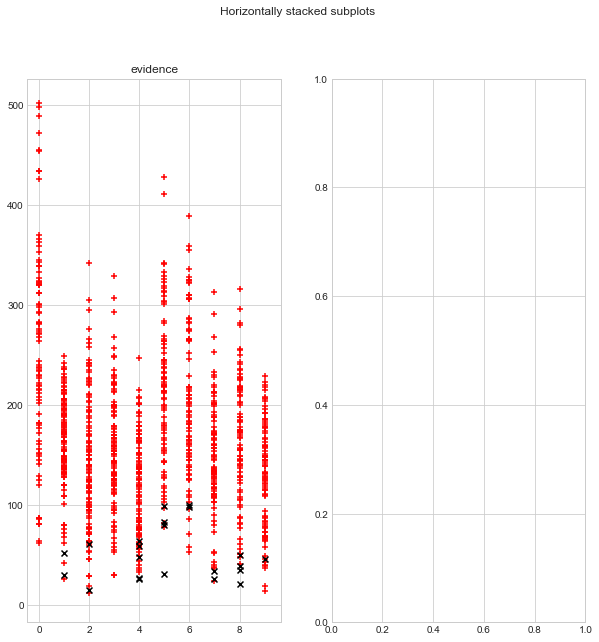

In [58]:
###keras KL activated model 47 epochs
Predictions = displayEvidence(model,test_ds)

10000


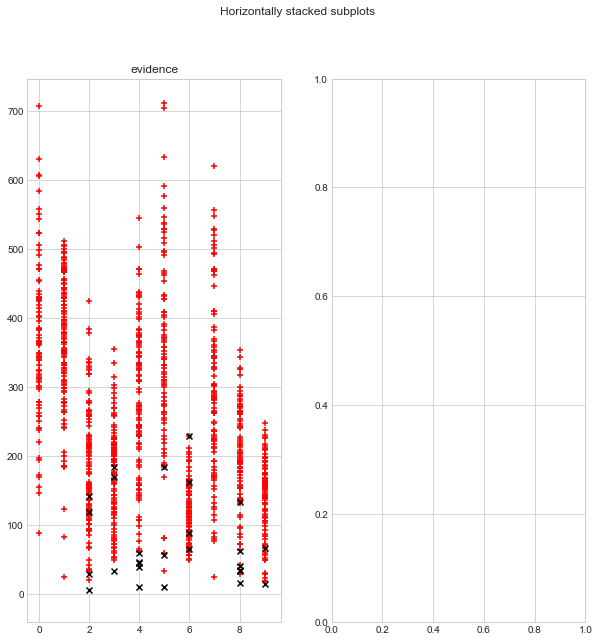

In [24]:
### no KL 
Predictions = displayEvidence(model,test_ds)

In [59]:
threshold = 0
Predictions['uncertainty'] = 10 / (10+Predictions['evidence'])
correct_rows = Predictions.loc[(Predictions['Acc'] == True) & (Predictions['evidence'] >threshold)]
incorrect_rows = Predictions.loc[(Predictions['Acc'] == False) & (Predictions['evidence'] > threshold)]
# incorrect_rows = Predictions.loc[(Predictions['evidence'] > 40)]
print(correct_rows.count())

print(incorrect_rows.count())
print(incorrect_rows.head())
# print(incorrect_rows.sort_values("evidence"))

uncertainty_correct_rows = Predictions.loc[(Predictions['Acc'] == True) & (Predictions['evidence'] >threshold)]
uncertainty_incorrect_rows = Predictions.loc[(Predictions['Acc'] == False) & (Predictions['evidence'] > threshold)]


class          977
evidence       977
Acc            977
uncertainty    977
dtype: int64
class          22
evidence       22
Acc            22
uncertainty    22
dtype: int64
     class   evidence  Acc  uncertainty
114      4  58.336926  0.0     0.146334
148      2  14.518316  0.0     0.407858
216      6  97.689018  0.0     0.092860
246      4  26.732870  0.0     0.272236
320      2  60.387310  0.0     0.142071


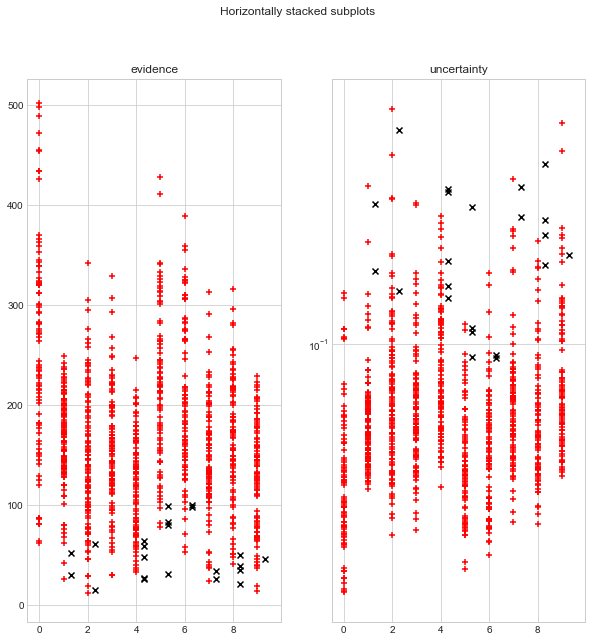

In [60]:
fig, axs = plt.subplots(1, 2)
plt.yscale('log')
fig.suptitle('Horizontally stacked subplots')
axs[0].scatter(correct_rows['class'],correct_rows['evidence'],c ='r',marker='+')
axs[0].scatter(incorrect_rows['class']+.3,incorrect_rows['evidence'],c ='k',marker='x')
axs[0].set_title("evidence")

axs[1].scatter(correct_rows['class'],correct_rows['uncertainty'],c ='r',marker='+')
axs[1].scatter(incorrect_rows['class']+.3,incorrect_rows['uncertainty'],c ='k',marker='x')
axs[1].set_title("uncertainty")
fig.set_size_inches(10, 10)


In [441]:
def GetResultsCSV_evidence(model,dataset,suffix="", validation=True):
        num_outputs = len(model.outputs) # the number of output layers for the purpose of providing labels
        train_ds, test_ds, validation_ds = (dataset)
        predictions = []
        labels = []
        #already compiled
        # model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.optimizers.SGD(lr=0.001), metrics=['accuracy'])
        iterator = iter(test_ds)
        print(len(test_ds))

#         for j in range(len(test_ds)):
        for j in range(100):
            print("prediction: {} of {}".format(j,len(test_ds)),end='\r')
            item = iterator.get_next()
            prediction = model.predict(item[0])
            # print("predictions {}".format(prediction))
            predictions.append(prediction)
            # print(prediction)
            labels.append(item[1].numpy().tolist())
        print("labels")
        # print(labels)
        for i, val in enumerate(labels):
            # print(i)
            labels[i]= [np.argmax(val)]* num_outputs

        predEvidence_fail =[]
        predEvidence_fail_uncert =[]
        predEvidence_true = []
        predEvidence_true_uncert =[]
        predEvidence_fail_label =[]
        predEvidence_true_label =[]
        predClasses =[]
        predRaw=[]
        print("predictions complete, analyizing") 
        for i,output in enumerate(predictions):
            for k, pred in enumerate(output):

                pred_classes=[]
                pred_evidence = []
                pred_Raw=[]
                print("image: {} of {}".format(i,len(predictions)),end='\r')
                # print("output: ",i)
                if(type(pred[0])==list):
                    for l, branch in enumerate(pred):
                        pred_Raw.append(branch)
                        Pclass = np.argmax(branch)
                        pred_classes.append(Pclass) 
                        evidence = exp_evidence(branch).numpy()
                        total_evidence = evidence
                        match = tf.reshape(tf.cast(tf.equal(Pclass, labels[i]), tf.float32),(-1,1))                    
                        if l !=0:
                            if match.numpy()[0]==0:
                                # print("match", match.numpy(),total_evidence.numpy())
                                
                                ev_fail = evidence + 1
                                predEvidence_fail.append(ev_fail.numpy())
                                predEvidence_fail_uncert.append(K / ev_fail.numpy())
                                predEvidence_fail_label.append(labels[i][0])
                            else:
                                # print(labels[i])

                                ev_succ = evidence
                                predEvidence_true.append(ev_succ)
                                predEvidence_true_uncert.append(K /ev_succ.numpy())
                                predEvidence_true_label.append(labels[i][0])
                                                
                            # print(total_evidence.numpy())
                        pred_evidence.append(total_evidence)
                else:
                    # print("predictions", pred)

                    pred_Raw.append(pred)
                    Pclass = np.argmax(pred)
                    pred_classes.append(Pclass) 
                    evidence = tf.reduce_sum(exp_evidence(pred)).numpy()
                    # print(evidence)
                    total_evidence = evidence
                    match = tf.reshape(tf.cast(tf.equal(Pclass, labels[i]), tf.float32),(-1,1))  
                    # print(match)                  
                    if match.numpy()[0]==0:
                        # print("fail")
                        # print("match", match.numpy(),total_evidence.numpy())
                        
                        ev_fail = (evidence)*(1-0) / (1+1e-20) 
                        predEvidence_fail.append(ev_fail)
                        predEvidence_fail_uncert.append(K/ (K + ev_fail))
                        predEvidence_fail_label.append(labels[i][0])
                    else:
                        # print(labels[i])

                        ev_succ = (evidence)*1 / (1+1e-20)
                        predEvidence_true.append(ev_succ)
                        predEvidence_true_uncert.append(K/ (K + ev_succ))
                        predEvidence_true_label.append(labels[i][0])
                                            
                        # print(total_evidence.numpy())
                    pred_evidence.append(total_evidence)
        
              
        labelClasses = [0,1,2,3,4,5,6,7,8,9]
        # predClasses = pd.DataFrame(predClasses)
        labels = pd.DataFrame(labels)
        predEvidence_fail = pd.DataFrame([predEvidence_fail])
        predEvidence_true = pd.DataFrame([predEvidence_true])
        
        import matplotlib.pyplot as plt

        # predEvidence_true = [K / K+ x for x in predEvidence_true]
        # predEvidence_fail = [K / K+ x for x in predEvidence_fail]

        # print(len(predEvidence_true))
        # print(len(predEvidence_true_label))
        print("mean Success: ",tf.reduce_mean(predEvidence_true))
        # print(predEvidence_true)
        print("mean Fail: ",tf.reduce_mean(predEvidence_fail))

        predEvidence_fail_label = [x+.2 for x in predEvidence_fail_label]
        fig, axs = plt.subplots(1, 2)
        fig.suptitle('Horizontally stacked subplots')
        axs[0].scatter(predEvidence_true_label,predEvidence_true,c ='r',marker='+')
        axs[0].scatter(predEvidence_fail_label,predEvidence_fail,c ='k',marker='x')
        axs[0].set_title("evidence")

        axs[1].scatter(predEvidence_true_label,predEvidence_true_uncert,c ='r',marker='*')
        axs[1].scatter(predEvidence_fail_label,predEvidence_fail_uncert,c ='k',marker='*')
        axs[1].set_title("uncertainty")

        fig.set_size_inches(10, 10)
        plt.show()
        
        
        
        return
        
        

10000
labelstion: 9999 of 10000
predictions complete, analyizing
mean Success:  tf.Tensor(11.712669773054586, shape=(), dtype=float64)
mean Fail:  tf.Tensor(11.542338025336171, shape=(), dtype=float64)


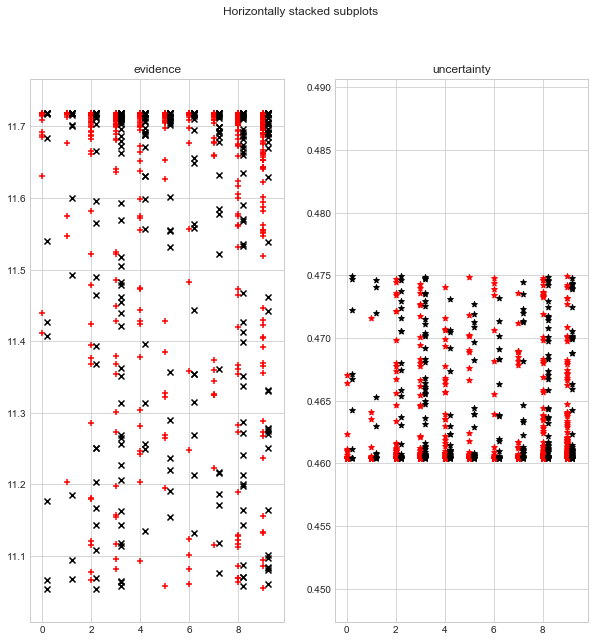

In [272]:
results = GetResultsCSV_evidence(model,(train_ds, test_ds, validation_ds),suffix="new_model", validation=True)

10000
labelstion: 99 of 10000
predictions complete, analyizing
mean Success:  tf.Tensor(11.716626070966624, shape=(), dtype=float64)
mean Fail:  tf.Tensor(11.55577278137207, shape=(), dtype=float64)


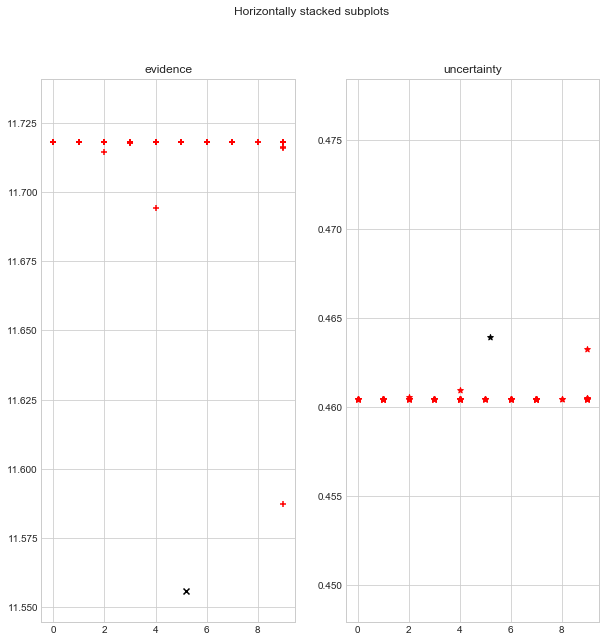

In [274]:
results = GetResultsCSV_evidence(model,(train_ds, test_ds, validation_ds),suffix="new_model", validation=True)

In [425]:
results.head()

AttributeError: 'NoneType' object has no attribute 'head'